**scrapping IMBD top 250**

In [ ]:
from bs4 import BeautifulSoup
import requests
from pprint import pprint
from urllib.request import Request, urlopen

url = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'

response = requests.get(url)
html = response.text
soup = BeautifulSoup(html, 'html.parser')

titles = soup.find_all('td', class_='titleColumn')


#récupere la liste des acteurs connus
list_actors_famous = []
for page in range(1, 21):
    url_actor_star = f'https://www.allocine.fr/personne/top/les-plus-vues/ever/?page={page}'
    #le f sert à formater l'URL
    response_actor = requests.get(url_actor_star)
    actor_soup = BeautifulSoup(response_actor.content, 'html.parser')
    actors_famous = actor_soup.find_all('a', class_= "meta-title-link")
  

#mettre tous les acteurs scrapper dans une liste   
    for actor in actors_famous:
        actor_star = actor.text.strip()
        list_actors_famous.append(actor_star)


#récupérer la liste  des réalisateurs avec un golden 
list_director_famous = []
url_director_famous = f'https://www.allocine.fr/festivals/festival-118/palmares/prix-18350635/'
response_director = requests.get(url_director_famous)
director_soup = BeautifulSoup(response_director.content, 'html.parser')
director_famous = director_soup.find_all('a', href=lambda href: href and '/personne/fichepersonne_gen_cpersonne=' in href)

for director in director_famous:
  director_star = director.text.strip()
  list_director_famous.append(director_star)

import pandas as pd

#Initialiser une liste vide pour stocker les dictionnaires des films
movies_list = []


#scrapper les infos
for title in titles:
    movie_title = title.a.text
    movie_year = title.span.text.strip('()')
    ratings = title.find_next_sibling('td', class_= 'ratingColumn')
    
 #aller scrapper sur les pages de chaque film
    movie_url = 'https://www.imdb.com' + title.a['href']
    req = Request(
    url=movie_url, 
    headers={'User-Agent': 'Mozilla/5.0'}
    )
    
    movie_response = urlopen(req).read()
    movie_soup = BeautifulSoup(movie_response, 'html.parser')
    genre_span = movie_soup.find('span', {'class': 'ipc-chip__text'}).text.strip()
        
    director_movie = movie_soup.find('a', class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link").text.strip()
   
    #créer une liste pour les réalisateurs en commun avec allociné 
    director_common = []  
    #essayer de n'afficher que les réal avec golden
    if director_movie in list_director_famous:
        director_common.append(director_movie)

    #créer une nouvelle liste pour stocker 'yes or no'
    director_known = []     
    #compter 1 si le director à eu un golden globes
    common_director_count = len(director_common)

    if common_director_count == 1:
      director_known.append("yes")
    else:
      director_known.append("no")

    
    actors_list = movie_soup.find_all("a", class_="sc-bfec09a1-1 fUguci")
    #créer une liste pour les acteurs en commun avec allociné
    actors_common = []   
    #essayer de n'afficher que les acteurs célèbres
    for actor in actors_list:
        actor_name = actor.text.strip()
        if actor_name in list_actors_famous:
            actors_common.append(actor_name)

    common_actors_count = len(actors_common)
    
    movie_dict = {
        'title': movie_title,
        'year': movie_year,
        'rating': float(ratings.text),
        'genre':genre_span,
        'director': director_movie,
        'director get a golden globes ?': director_known,
        'actor': actors_common,
        'how many famous actors are in it?': common_actors_count
    }
    # Ajouter le dictionnaire du film à la liste
    movies_list.append(movie_dict)


# Créer un DataFrame à partir de la liste de dictionnaires
df = pd.DataFrame(movies_list)
 
print(df)


                        title  year  rating      genre              director  \
0    The Shawshank Redemption  1994     9.2      Drama        Frank Darabont   
1               The Godfather  1972     9.2      Crime  Francis Ford Coppola   
2             The Dark Knight  2008     9.0     Action     Christopher Nolan   
3       The Godfather Part II  1974     9.0      Crime  Francis Ford Coppola   
4                12 Angry Men  1957     9.0      Crime          Sidney Lumet   
..                        ...   ...     ...        ...                   ...   
245      John Wick: Chapter 4  2023     8.0     Action        Chad Stahelski   
246            The Iron Giant  1999     8.0  Animation             Brad Bird   
247                  The Help  2011     8.0      Drama           Tate Taylor   
248                   Aladdin  1992     8.0  Animation          Ron Clements   
249        Dances with Wolves  1990     8.0  Adventure         Kevin Costner   

    director get a golden globes ?  \
0

............................................................................................................................................................................................................................................

**Visualisation**


genre et note moyenne

In [ ]:
import matplotlib.pyplot as plt

# Grouper les films par genre, et appliquer des fonctions d'agrégation
genres_agg = df.groupby('genre').agg({'title': 'count', 'rating': 'mean'})

# Renommer les colonnes pour correspondre aux noms demandés
genres_agg = genres_agg.rename(columns={'title': 'nombre de films', 'rating': 'note moyenne'})

# Trier les résultats par note moyenne décroissante
genres_agg = genres_agg.sort_values(by='note moyenne', ascending=False)

# Afficher le tableau des résultats
print(genres_agg.to_string(index=True))

           nombre de films  note moyenne
genre                                   
Western                  1      8.400000
Crime                   35      8.337143
Action                  47      8.304255
Mystery                  4      8.300000
Horror                   4      8.250000
Drama                   69      8.236232
Biography               22      8.222727
Animation               23      8.204348
Comedy                  23      8.200000
Adventure               21      8.180952
Film-Noir                1      8.100000


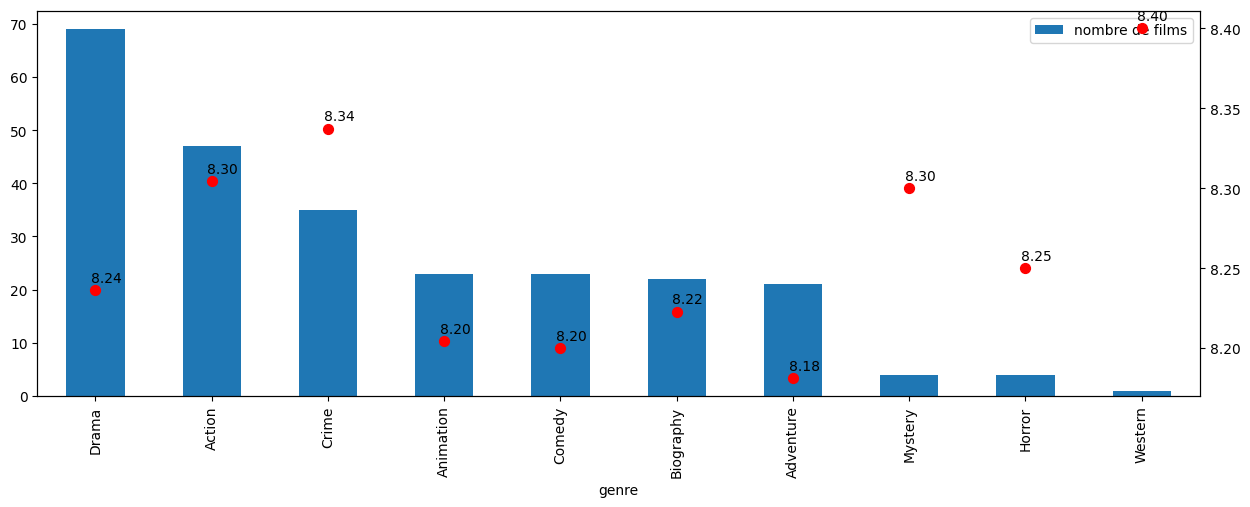

In [ ]:
# Trier les résultats par nombre de films décroissant et afficher les 10 premiers
top_genre = genres_agg.sort_values(by='nombre de films', ascending=False).head(10)

# Afficher un graphique à barres du nombre de films et de la note moyenne par acteur
ax = top_genre.plot(kind='bar', y='nombre de films', figsize=(15, 5))

#creer un autre axe pour le rating
ax2 = ax.twinx()

# Créer un graphique à points pour la note moyenne
ax2.scatter(x=top_genre.index, y=top_genre['note moyenne'], color='red', s=50)

for index, row in top_genre.iterrows():
    ax2.annotate(f"{row['note moyenne']:.2f}", (index, row['note moyenne']), xytext=(8, 6),
                 textcoords='offset points', ha='center', color='black')

# Afficher le graphique
plt.show()

répartition films par genre

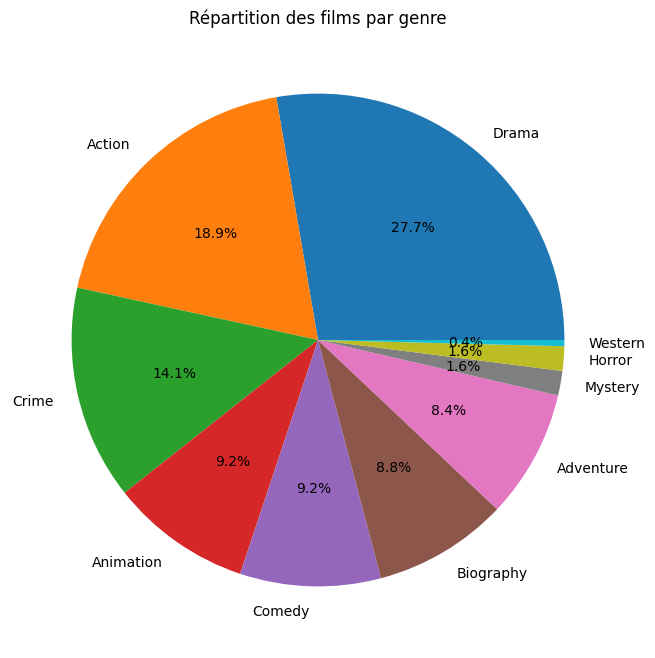

In [ ]:
# Trier les résultats par nombre de films décroissant et afficher les 10 premiers
top_genre = genres_agg.sort_values(by='nombre de films', ascending=False).head(10)

# Créer un graphique circulaire du nombre de films par genre
plt.figure(figsize=(8, 8))
plt.pie(top_genre['nombre de films'], labels=top_genre.index, autopct='%1.1f%%')
plt.title('Répartition des films par genre')
plt.show()


année et note moyenne

In [ ]:
# Grouper les films par année, 10 ans, et appliquer des fonctions d'agrégation
df['year'] = pd.to_numeric(df['year'])
df['annee'] = (df['year'] // 10) * 10

annee_agg = df.groupby('annee').agg({'title': 'count', 'rating': 'mean'})

# Renommer les colonnes pour correspondre aux noms demandés
annee_agg = annee_agg.rename(columns={'title': 'nombre de films', 'rating': 'note moyenne'})

# Trier les résultats par note moyenne décroissante
annee_agg = annee_agg.sort_values(by='note moyenne', ascending=False)

# Afficher 
print(annee_agg.to_string(index=True))

       nombre de films  note moyenne
annee                               
1990                42      8.361905
1970                18      8.288889
2000                48      8.254167
1980                26      8.242308
1960                18      8.238889
1950                23      8.234783
2010                43      8.213953
1940                12      8.191667
1930                 7      8.171429
2020                 7      8.142857
1920                 6      8.133333


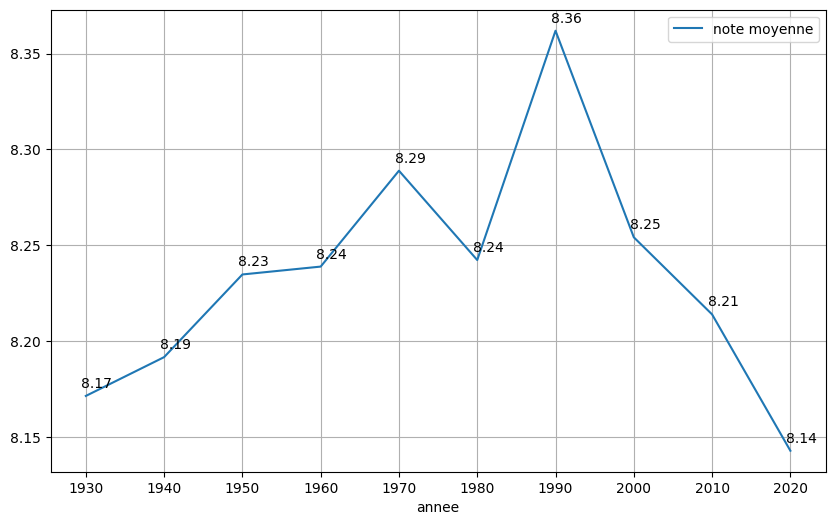

In [ ]:
# Trier les résultats par nombre année 10 ans et afficher les 10 premiers
top_annee = annee_agg.sort_values(by='annee', ascending=False).head(10)

# Afficher un graphique en ligne de la note moyenne
ax = top_annee.plot(kind='line', y='note moyenne', figsize=(10, 6))

# Ajouter les annotations des notes moyennes sur le graphique
for index, row in top_annee.iterrows():
    ax.annotate(f"{row['note moyenne']:.2f}", (index, row['note moyenne']), xytext=(8, 6),
                 textcoords='offset points', ha='center', color='black')
    
plt.grid(True)
plt.xticks(top_annee.index)

# Afficher le graphique
plt.show()

directeur, nombre de film et rating


In [ ]:
# Grouper les films par genre, et appliquer des fonctions d'agrégation
director_agg = df.groupby('director').agg({'title': 'count', 'rating': 'mean'})

# Renommer les colonnes pour correspondre aux noms demandés
director_agg = director_agg.rename(columns={'title': 'nombre de films', 'rating': 'note moyenne'})

# Trier les résultats par note moyenne décroissante
director_agg = director_agg.sort_values(by='note moyenne', ascending=False)

# Afficher le tableau des résultats
print(director_agg.to_string(index=True))

                                  nombre de films  note moyenne
director                                                       
Frank Darabont                                  2      8.900000
Francis Ford Coppola                            3      8.866667
Peter Jackson                                   3      8.800000
Lana Wachowski                                  1      8.700000
Irvin Kershner                                  1      8.700000
Robert Zemeckis                                 2      8.650000
Jonathan Demme                                  1      8.600000
Fernando Meirelles                              1      8.600000
Roberto Benigni                                 1      8.600000
Christopher Nolan                               7      8.528571
Roger Allers                                    1      8.500000
Damien Chazelle                                 1      8.500000
George Lucas                                    1      8.500000
Tony Kaye                               

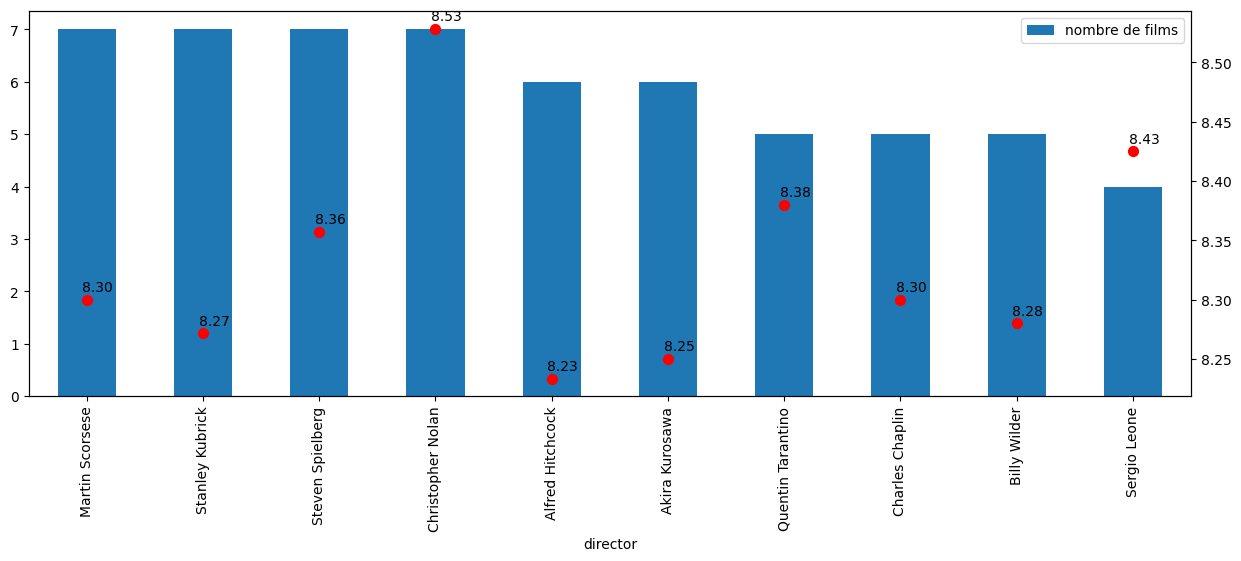

In [ ]:
# Trier les résultats par nombre de films décroissant et afficher les 10 premiers
top_director = director_agg.sort_values(by='nombre de films', ascending=False).head(10)

# Afficher un graphique à barres du nombre de films et de la note moyenne par acteur
ax = top_director.plot(kind='bar', y='nombre de films', figsize=(15, 5))

#creer un autre axe pour le rating
ax2 = ax.twinx()

# Créer un graphique à points pour la note moyenne
ax2.scatter(x=top_director.index, y=top_director['note moyenne'], color='red', s=50)

for index, row in top_director.iterrows():
    ax2.annotate(f"{row['note moyenne']:.2f}", (index, row['note moyenne']), xytext=(8, 6),
                 textcoords='offset points', ha='center', color='black')
# Afficher le graphique
plt.show()

................................................................................................................................................................................................................................................

**scrapping sortie IMBD**

In [ ]:
url_sortie = "https://www.imdb.com/calendar/?ref_=rlm&region=BE&type=MOVIE"
req = Request(
url= url_sortie, 
headers={'User-Agent': 'Mozilla/5.0'}
)
    
response_sortie = urlopen(req).read()
sortie_soup = BeautifulSoup(response_sortie, 'html.parser')

#scrapper les infos
movie_sortie = sortie_soup.find_all('div', class_= "ipc-metadata-list-summary-item__c")

#Initialiser une liste vide pour stocker les dictionnaires des films
sorties_list = []

#scrapper chaque infos duu films
for movie in movie_sortie:
    sortie_title = movie.find('a', class_= "ipc-metadata-list-summary-item__t").text.strip()
    
    movie_sortie_url = 'https://www.imdb.com' + movie.a['href']
    req = Request(
    url=movie_sortie_url, 
    headers={'User-Agent': 'Mozilla/5.0'}
    )
    
    movie_sortie_response = urlopen(req).read()
    sortie_soup = BeautifulSoup(movie_sortie_response, 'html.parser')
    genre_sortie = sortie_soup.find('span', {'class': 'ipc-chip__text'}).text.strip()
    director_sortie = sortie_soup.find('a', class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link").text.strip()
    
    #créer une liste pour les réalisateurs en commun avec allociné 
    director_sortie_common = []  
    #essayer de n'afficher que les réal avec golden
    if director_sortie in list_director_famous:
        director_sortie_common.append(director_sortie)

    #créer une nouvelle liste pour stocker 'yes or no'
    director_sortie_known = []     
    #compter 1 si le director à eu un golden globes
    common_director_sortie_count = len(director_sortie_common)

    if common_director_sortie_count == 1:
      director_sortie_known.append("yes")
    else:
      director_sortie_known.append("no")
     
    #scrapper les acteurs des films
    actors_sortie_list = sortie_soup.find_all("a", class_="sc-bfec09a1-1 fUguci")
    actors_common_sortie = []   
    #essayer de n'afficher que les acteurs célèbres
    for actor in actors_sortie_list:
        actor_name_sortie = actor.text.strip()
        if actor_name_sortie in list_actors_famous:
            actors_common_sortie.append(actor_name_sortie)

    common_actors_sortie_count = len(actors_common)
    
    movie_sortie = {
        'title': sortie_title,
        'genre':genre_sortie,
        'director': director_sortie,
        'director get a golden globes ?': director_sortie_known,
        'actor': actors_common_sortie,
        'how many famous actors are in it?': common_actors_sortie_count
    }
    
    # Ajouter le dictionnaire du film à la liste
    sorties_list.append(movie_sortie)


# Créer un DataFrame à partir de la liste de dictionnaires
df_sorties = pd.DataFrame(sorties_list)
 
print(df_sorties)


                                                title      genre  \
0          Spider-Man: Across the Spider-Verse (2023)  Animation   
1                                The Boogeyman (2023)     Horror   
2                            To Catch a Killer (2023)     Action   
3             Transformers: Rise of the Beasts (2023)     Action   
4                                       Strays (2023)  Animation   
5                                Spinning Gold (2023)  Biography   
6                                    The Flash (2023)     Action   
7                              About My Father (2023)     Comedy   
8                                    Elemental (2023)  Animation   
9                                Asteroid City (2023)     Comedy   
10                            No Hard Feelings (2023)     Comedy   
11       Indiana Jones and the Dial of Destiny (2023)     Action   
12                Ruby Gillman, Teenage Kraken (2023)  Animation   
13                Harold and the Purple Crayon (

......................................................................................................................................................................................

**Modelling**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df.head()

,title,year,rating,genre,director,director get a golden globes ?,actor,how many famous actors are in it?
0,The Shawshank Redemption,1994,9.2,Drama,Frank Darabont,[no],[Morgan Freeman],1
1,The Godfather,1972,9.2,Crime,Francis Ford Coppola,[yes],[Al Pacino],1
2,The Dark Knight,2008,9.0,Action,Christopher Nolan,[no],"[Christian Bale, Gary Oldman, Morgan Freeman, ...",4
3,The Godfather Part II,1974,9.0,Crime,Francis Ford Coppola,[yes],"[Al Pacino, Robert De Niro]",2
4,12 Angry Men,1957,9.0,Crime,Sidney Lumet,[yes],[],0


**regression linear**

In [ ]:
from bs4 import BeautifulSoup
import requests
from pprint import pprint
from urllib.request import Request, urlopen
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

In [ ]:
# Encoder les variables catégorielles (genre) en variables numériques
label_encoder = LabelEncoder()
df['genre_encoded'] = label_encoder.fit_transform(df['genre'])

,title,year,rating,genre,director,director get a golden globes ?,actor,how many famous actors are in it?,genre_encoded
0,The Shawshank Redemption,1994,9.2,Drama,Frank Darabont,[no],[Morgan Freeman],1,6
1,The Godfather,1972,9.2,Crime,Francis Ford Coppola,[yes],[Al Pacino],1,5
2,The Dark Knight,2008,9.0,Action,Christopher Nolan,[no],"[Christian Bale, Gary Oldman, Morgan Freeman, ...",4,0
3,The Godfather Part II,1974,9.0,Crime,Francis Ford Coppola,[yes],"[Al Pacino, Robert De Niro]",2,5
4,12 Angry Men,1957,9.0,Crime,Sidney Lumet,[yes],[],0,5


In [ ]:
# Préparer les variables d'entrée (features) et de sortie (target)
X = df[['director get a golden globes ?', 'how many famous actors are in it?', 'genre_encoded']]
y = df['rating']

In [ ]:
# Encoder la variable binaire 'director get a golden globes ?' en variable numérique
X['director_get_gg_encoded'] = X['director get a golden globes ?'].map({'yes': 1, 'no': 0})

<ipython-input-32-14393b2a2b3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['director_get_gg_encoded'] = X['director get a golden globes ?'].map({'yes': 1, 'no': 0})


In [ ]:
# Supprimer la colonne originale 'director get a golden globes ?'
X.drop('director get a golden globes ?', axis=1, inplace=True)

<ipython-input-33-bd3619b0e3ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('director get a golden globes ?', axis=1, inplace=True)


In [ ]:
# Effectuer un encodage one-hot pour la variable catégorielle 'genre_encoded', Cela permet de traiter les différentes catégories de genre comme des variables distinctes
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['genre_encoded'])], remainder='passthrough')
X_encoded = ct.fit_transform(X)

In [ ]:
# Créer un modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle
model.fit(X_encoded, y)

LinearRegression()

In [ ]:
# Prédire le rating pour de nouvelles données
new_data = pd.DataFrame({
    'director get a golden globes ?': ['yes'],
    'how many famous actors are in it?': [3],
    'genre_encoded': [2]  # Valeur encodée correspondant au genre du film
})


In [ ]:
# Encoder les nouvelles données de la même manière que les données d'entraînement
new_data['director_get_gg_encoded'] = new_data['director get a golden globes ?'].map({'yes': 1, 'no': 0})
new_data.drop('director get a golden globes ?', axis=1, inplace=True)
new_data_encoded = ct.transform(new_data)


In [ ]:
# Prédire le rating pour les nouvelles données
predicted_ratings = model.predict(new_data_encoded)

In [ ]:
# Afficher les prédictions
print(predicted_ratings)

[8.35881533]


**prediction sorties**

In [ ]:
df_sorties.head()

,title,genre,director,director get a golden globes ?,actor,how many famous actors are in it?
0,Spider-Man: Across the Spider-Verse (2023),Animation,Joaquim Dos Santos,[no],[Oscar Isaac],1
1,The Boogeyman (2023),Horror,Rob Savage,[no],[],1
2,To Catch a Killer (2023),Action,Damián Szifron,[no],[Shailene Woodley],1
3,Transformers: Rise of the Beasts (2023),Action,Steven Caple Jr.,[no],[],1
4,Strays (2023),Animation,Josh Greenbaum,[no],[],1


In [ ]:
#Encoder la colonne 'genre' en utilisant le LabelEncoder
df_sorties['genre_encoded'] = label_encoder.transform(df_sorties['genre'])


In [ ]:
# Préparer les variables d'entrée pour la prédiction
X_sorties = df_sorties[['director get a golden globes ?', 'how many famous actors are in it?', 'genre_encoded']]


In [ ]:
# Encoder la variable binaire 'director get a golden globes ?' en variable numérique
X_sorties['director_get_gg_encoded'] = X_sorties['director get a golden globes ?'].apply(lambda x: 1 if len(x) > 0 else 0)

<ipython-input-73-cb24e78bcd39>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sorties['director_get_gg_encoded'] = X_sorties['director get a golden globes ?'].apply(lambda x: 1 if len(x) > 0 else 0)


In [ ]:
# Supprimer la colonne originale 'director get a golden globes ?'
X_sorties.drop('director get a golden globes ?', axis=1, inplace=True)

<ipython-input-74-336d02463c49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sorties.drop('director get a golden globes ?', axis=1, inplace=True)


In [ ]:
# Encoder les variables catégorielles en variables numériques
X_sorties_encoded = ct.transform(X_sorties)

In [ ]:
# Prédire le rating pour les nouvelles données
predicted_ratings_sorties = model.predict(X_sorties_encoded)

In [ ]:
# Ajouter les prédictions au DataFrame 'df_sorties'
df_sorties['predicted_rating'] = predicted_ratings_sorties

In [ ]:
# Afficher les résultats
print(df_sorties[['title', 'predicted_rating']])

                                                title  predicted_rating
0          Spider-Man: Across the Spider-Verse (2023)          8.314575
1                                The Boogeyman (2023)          8.340605
2                            To Catch a Killer (2023)          8.353687
3             Transformers: Rise of the Beasts (2023)          8.353687
4                                       Strays (2023)          8.314575
5                                Spinning Gold (2023)          8.270464
6                                    The Flash (2023)          8.353687
7                              About My Father (2023)          8.296912
8                                    Elemental (2023)          8.314575
9                                Asteroid City (2023)          8.296912
10                            No Hard Feelings (2023)          8.296912
11       Indiana Jones and the Dial of Destiny (2023)          8.353687
12                Ruby Gillman, Teenage Kraken (2023)          8